In [2]:
import numpy as np
import torch 
from tqdm import *

from graphvampnets.processing.dataprocessing import Preprocessing, Postprocessing_vamp
from graphvampnets.processing.graphloader import GraphPairLoader
from graphvampnets.layers.graph import GraphVAMPNetLayer
from graphvampnets.vamp.vampnet import VAMPNet
from graphvampnets.utils import set_random_seed, ContourPlot2D

### Preprocess data
##### (Note that the 9d9f dataset is so large that appropriate downsampling is recommended)

In [3]:
import mdtraj as md
### Here we use mdtraj to convert original xtc file to pairwise distances data.
### To install mdtraj, use command 'pip install mdtraj'

pairs = []
idx = [0,2,4,6,8,10,12,13,15,17,19,20,22,24,44,46,48,50,52,54,56,57,59,61,63,64,66,68]
for i in range(27):
    for j in range(i+1,28):
        pairs.append([idx[i],idx[j]])

pw = []
for i in range(0, 40):
    t = md.load("../data/original_trajs/allTraj/npt-pro-traj%i.xtc"%(i+1), top="../data/original_trajs/9d9f.gro")
    d = md.compute_distances(traj=t, atom_pairs=pairs)
    pw.append(d)

In [4]:
pre = Preprocessing()
graph_data_for_training, graph_data_for_projection = pre.transform2graph(pw,num_nbrs=10,num_atoms=28)

In [5]:
print(len(graph_data_for_training))
print(graph_data_for_training[0].shape)

print(len(graph_data_for_projection))
print(graph_data_for_projection[0].shape)

40
(50001, 280, 3)
40
(14000281, 3)


### Train GraphVAMPnets

In [4]:
pre = Preprocessing()
graph_dataset = pre.create_dataset(graph_data_for_training,lag_time=100)
print(len(graph_dataset))

1996040


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
print(device)

cuda


In [6]:
set_random_seed(42)

val = int(len(graph_dataset)*0.2)
train_data, val_data = torch.utils.data.random_split(graph_dataset, [len(graph_dataset)-val, val])

loader_train = GraphPairLoader(num_atoms=28, dataset=train_data, batch_size=1000, shuffle=True)
loader_val = GraphPairLoader(num_atoms=28, dataset=val_data, batch_size=1000, shuffle=False)

atom_class_idx = torch.tensor([4,5,6,5,5,6,5,3,0,1,2,2,1,0,4,5,6,5,5,6,5,3,0,1,2,2,1,0])
lobe = GraphVAMPNetLayer(num_atoms=28, num_conv=5, atom_emb_dim=8, dmin=0, dmax=6, step=0.5, graph_emb_dim=2, atom_class_idx=atom_class_idx)
lobe = lobe.to(device)
from copy import deepcopy
lobe_lagged = deepcopy(lobe).to(device=device)
net = VAMPNet(lobe=lobe, lobe_lagged=lobe_lagged, learning_rate=1e-3, device=device)
net.fit(loader_train, n_epochs=50,
                    validation_loader=loader_val, progress=tqdm)

epoch:   2%|▏         | 1/50 [06:12<5:03:59, 372.22s/it]

0 1.6438490152359009


epoch:   4%|▍         | 2/50 [12:16<4:54:12, 367.77s/it]

1 1.661719799041748


epoch:   6%|▌         | 3/50 [18:20<4:46:39, 365.94s/it]

2 1.671517014503479


epoch:   8%|▊         | 4/50 [24:28<4:41:05, 366.65s/it]

3 1.67559814453125


epoch:  10%|█         | 5/50 [30:32<4:34:13, 365.64s/it]

4 1.676902413368225


epoch:  12%|█▏        | 6/50 [36:37<4:27:55, 365.36s/it]

5 1.6777960062026978


epoch:  14%|█▍        | 7/50 [42:39<4:21:12, 364.47s/it]

6 1.6815084218978882


epoch:  16%|█▌        | 8/50 [48:39<4:14:04, 362.97s/it]

7 1.6839697360992432


epoch:  18%|█▊        | 9/50 [54:42<4:08:02, 363.00s/it]

8 1.6828736066818237


epoch:  20%|██        | 10/50 [1:00:40<4:00:52, 361.32s/it]

9 1.685443639755249


epoch:  22%|██▏       | 11/50 [1:06:37<3:54:10, 360.28s/it]

10 1.6861779689788818


epoch:  24%|██▍       | 12/50 [1:12:35<3:47:43, 359.56s/it]

11 1.6865049600601196


epoch:  26%|██▌       | 13/50 [1:18:38<3:42:13, 360.37s/it]

12 1.6867544651031494


epoch:  28%|██▊       | 14/50 [1:24:36<3:35:54, 359.85s/it]

13 1.6886422634124756


epoch:  30%|███       | 15/50 [1:30:35<3:29:43, 359.54s/it]

14 1.6867038011550903


epoch:  32%|███▏      | 16/50 [1:36:34<3:23:39, 359.39s/it]

15 1.6894887685775757


epoch:  34%|███▍      | 17/50 [1:42:33<3:17:32, 359.17s/it]

16 1.6889981031417847


epoch:  36%|███▌      | 18/50 [1:48:37<3:12:20, 360.65s/it]

17 1.6899316310882568


epoch:  38%|███▊      | 19/50 [1:54:36<3:06:09, 360.31s/it]

18 1.690493106842041


epoch:  40%|████      | 20/50 [2:00:35<2:59:50, 359.70s/it]

19 1.6907075643539429


epoch:  42%|████▏     | 21/50 [2:06:33<2:53:37, 359.22s/it]

20 1.6912429332733154


epoch:  44%|████▍     | 22/50 [2:12:35<2:48:05, 360.19s/it]

21 1.6910299062728882


epoch:  46%|████▌     | 23/50 [2:18:34<2:41:49, 359.61s/it]

22 1.6901557445526123


epoch:  48%|████▊     | 24/50 [2:24:32<2:35:40, 359.26s/it]

23 1.6922274827957153


epoch:  50%|█████     | 25/50 [2:30:30<2:29:29, 358.80s/it]

24 1.6912356615066528


epoch:  52%|█████▏    | 26/50 [2:36:27<2:23:24, 358.50s/it]

25 1.692870020866394


epoch:  54%|█████▍    | 27/50 [2:42:29<2:17:43, 359.28s/it]

26 1.6917626857757568


epoch:  56%|█████▌    | 28/50 [2:48:26<2:11:33, 358.77s/it]

27 1.69278085231781


epoch:  58%|█████▊    | 29/50 [2:54:22<2:05:15, 357.90s/it]

28 1.6925699710845947


epoch:  60%|██████    | 30/50 [3:00:19<1:59:14, 357.74s/it]

29 1.6928143501281738


epoch:  62%|██████▏   | 31/50 [3:06:20<1:53:30, 358.47s/it]

30 1.6922651529312134


epoch:  64%|██████▍   | 32/50 [3:12:15<1:47:14, 357.46s/it]

31 1.6932438611984253


epoch:  66%|██████▌   | 33/50 [3:18:12<1:41:17, 357.52s/it]

32 1.692299723625183


epoch:  68%|██████▊   | 34/50 [3:24:11<1:35:24, 357.76s/it]

33 1.6933917999267578


epoch:  70%|███████   | 35/50 [3:30:20<1:30:16, 361.12s/it]

34 1.6940521001815796


epoch:  72%|███████▏  | 36/50 [3:37:12<1:27:49, 376.37s/it]

35 1.69192373752594


epoch:  74%|███████▍  | 37/50 [3:43:46<1:22:43, 381.79s/it]

36 1.692931890487671


epoch:  76%|███████▌  | 38/50 [3:50:32<1:17:46, 388.91s/it]

37 1.6931802034378052


epoch:  78%|███████▊  | 39/50 [3:57:17<1:12:12, 393.89s/it]

38 1.6942843198776245


epoch:  80%|████████  | 40/50 [4:04:09<1:06:34, 399.45s/it]

39 1.6941111087799072


epoch:  82%|████████▏ | 41/50 [4:10:58<1:00:20, 402.33s/it]

40 1.693713903427124


epoch:  84%|████████▍ | 42/50 [4:17:43<53:45, 403.13s/it]  

41 1.6945949792861938


epoch:  86%|████████▌ | 43/50 [4:24:16<46:39, 399.89s/it]

42 1.6947416067123413


epoch:  88%|████████▊ | 44/50 [4:30:26<39:06, 391.12s/it]

43 1.6940252780914307


epoch:  90%|█████████ | 45/50 [4:36:34<31:59, 383.91s/it]

44 1.693363904953003


epoch:  92%|█████████▏| 46/50 [4:42:34<25:07, 376.91s/it]

45 1.6949785947799683


epoch:  94%|█████████▍| 47/50 [4:48:37<18:37, 372.56s/it]

46 1.693906307220459


epoch:  96%|█████████▌| 48/50 [4:54:38<12:18, 369.22s/it]

47 1.695168375968933


epoch:  98%|█████████▊| 49/50 [5:01:00<06:12, 372.98s/it]

48 1.694033145904541


49 1.6944347620010376


In [8]:
graphvampnets_cvs = net.transform(graph_data_for_projection,return_cv=True,lag_time=100)

In [9]:
torch.save(lobe.state_dict(),'../data/graphvampnets_model_50epochs.pt')
np.save('../data/graphvampnets_cvs_50epochs.npy',graphvampnets_cvs)
np.save('../data/training_scores_50epochs.npy',net.training_scores)
np.save('../data/validation_scores_50epochs.npy',net.validation_scores)

### Implied time scales plots of CVs

In [10]:
its = []
lag_times = [1,2,5,10,15,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
for lagt in lag_times:
    post = Postprocessing_vamp(n_dims=2,lag_time=np.int64(lagt),dtype=np.float64)
    its.append(post.fit(graphvampnets_cvs).time_scales)
its = np.array(its)

Text(0, 0.5, 'Time scales (ps)')

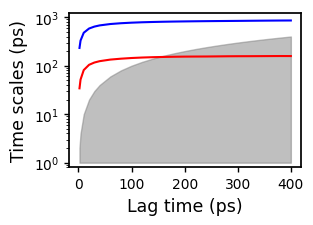

In [11]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(3,2)
plt.rcParams['axes.linewidth']=1.25
### One frame interval equals to 2 ps
plt.semilogy(np.array(lag_times)*2,its[:,0]*2,linewidth=1.5,c='blue')
plt.semilogy(np.array(lag_times)*2,its[:,1]*2,linewidth=1.5,c='red')
plt.ylim(0.8,1200)
plt.fill_between(np.array(lag_times)*2,np.ones(len(lag_times)),np.array(lag_times)*2,color='grey',alpha=0.5)
plt.tick_params(axis="both",labelsize=10,direction='out',length=3.75,width=1)
plt.xlabel('Lag time (ps)',fontsize=12.5)
plt.ylabel('Time scales (ps)',fontsize=12.5)

### Visualize CVs on $\theta_1$, $\theta_2$ space

In [12]:
theta = []
for i in range(1,41):
    tmp = np.load('../data/theta_trajs/traj%d.npy'%i)
    theta.append(tmp)

In [13]:
g = np.concatenate(graphvampnets_cvs)
g[:,0] = g[:,0] * -1 ### the sign of CV doesn't matter, here we change the sign for consistency.
t = np.concatenate(theta)

### Visualize CVs on 180*180 bins of theta1, theta2 space
cumulate_cv1 = np.zeros((180,180))
cumulate_cv2 = np.zeros((180,180))
cumulate_frame = np.zeros((180,180))
for i in range(len(g)):
    x = int(t[i,0])
    y = int(t[i,1])
    cumulate_cv1[x,y] = cumulate_cv1[x,y]+g[i,0]
    cumulate_cv2[x,y] = cumulate_cv2[x,y]+g[i,1]
    cumulate_frame[x,y] = cumulate_frame[x,y]+1
project_cv1 = cumulate_cv1/(cumulate_frame+np.ones((180,180))*1e-6)
project_cv2 = cumulate_cv2/(cumulate_frame+np.ones((180,180))*1e-6)
### rearange to compile the imshow plot
### before: colomn (top,down) -> theta1 (0,180)
### before: row (left,right) -> theta2 (0,180)
### after: row (left,right) -> theta1 (0,180)
### after: colomn (down,top) -> theta2 (0,180)
project_cv1 = project_cv1.T[:,::-1]
project_cv2 = project_cv2.T[:,::-1]

([<matplotlib.axis.YTick at 0x211ecbdfca0>,
 [Text(0, 0, '180'),
  Text(0, 60, '120'),
  Text(0, 120, '60'),
  Text(0, 180, '0')])

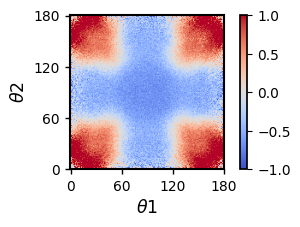

In [14]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(4,2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
plt.imshow(project_cv1,cmap='coolwarm')
cb=plt.colorbar() 
cb.ax.tick_params(labelsize=10)
plt.clim(-1,1)
plt.xlabel(r'$\theta1$',fontsize=12.5)
plt.ylabel(r'$\theta2$',fontsize=12.5)
plt.tick_params(axis="both",labelsize=10,direction='out',length=3.75,width=1)
plt.xticks([0,60,120,180],[0,60,120,180])
plt.yticks([0,60,120,180],[180,120,60,0])

([<matplotlib.axis.YTick at 0x20cd2e89e50>,
 [Text(0, 0, '180'),
  Text(0, 60, '120'),
  Text(0, 120, '60'),
  Text(0, 180, '0')])

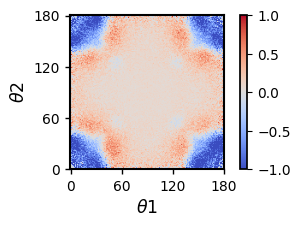

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4,2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
plt.imshow(project_cv2,cmap='coolwarm')
cb=plt.colorbar() 
cb.ax.tick_params(labelsize=10)
plt.clim(-1,1)
plt.xlabel(r'$\theta1$',fontsize=12.5)
plt.ylabel(r'$\theta2$',fontsize=12.5)
plt.tick_params(axis="both",labelsize=10,direction='out',length=3.75,width=1)
plt.xticks([0,60,120,180],[0,60,120,180])
plt.yticks([0,60,120,180],[180,120,60,0])

### Projection onto CVs constructed space

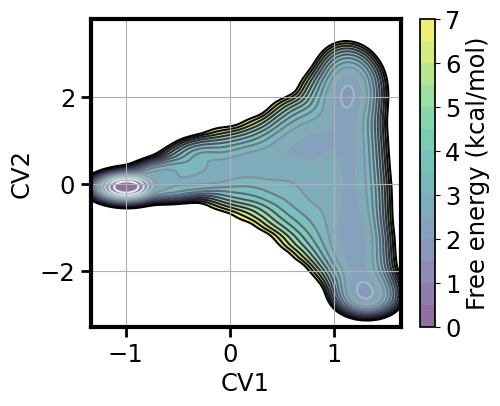

In [16]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(5,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g,ax,labelsize=17.5,xlabel='CV1',ylabel='CV2')